In [1]:
import glob
import chess_DL1_lib as lib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import chess
# import numpy as np

In [2]:
MODEL_NUM = 1
MODEL_VERSION = 3

path = "../Data/DataTrain"

letters_in = 'abcdefghijklmnopqrstuvwxy'
letters_out = 'z'

csv_files1 = []
csv_files2 = []

for let in letters_in:
    csv_files1.extend(glob.glob(f'{path}/Chess_Jan_{let}*'))
    csv_files1.extend(glob.glob(f'{path}/Chess_Feb_{let}*'))
    csv_files1.extend(glob.glob(f'{path}/Chess_Mar_{let}*')) # include in version 1-3

for let_ in letters_out:
    csv_files2.extend(glob.glob(f'{path}/Chess_Jan_{let_}*'))
    csv_files2.extend(glob.glob(f'{path}/Chess_Feb_{let_}*'))
    csv_files2.extend(glob.glob(f'{path}/Chess_Mar_{let_}*')) # include in version 1-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Models Trained
```
- DL1   (**Epochs**: 19,    **Optimizer**: Adam,               **LR**: 0.01,  **Train**: Jan_a-to-x,       **Test**: Jan_y-to-z).       **Batchsize**: 20000, **Time Per Epoch**: 130000 s/it
- DL1-2 (**Epochs**: TBD,   **Optimizer**: SGD(Momentum=0.9),  **LR**: 0.035, **Train**: [Jan/Feb]_a-to-x, **Test**: [Jan/Feb]_a-to-x). **Batchsize**: 40000, **Time Per Epoch**: TBD
```

| Version | Epochs | Optimizer    | LR    | Train         | Test          | Shuffle? | Batchsize |  Loaded?  | Time Per Epoch | Approx Total Time  |    Notes     |
|---------|--------|--------------|-------|---------------|---------------|----------|-----------|-----------|----------------|--------------------|--------------|
| 1       | 19     | Adam         | 0.01  | Jan (a-x)     | Jan (y-z)     | No       |  20000    |  No       | 130000 s/it    | 686.1 hours        | Legacy EL9.3 |
| 1-2     | 9      | SGD(Mom=0.9) | 0.04  | Jan-Feb (a-x) | Jan-Feb (y-z) | No       |  50000    |  Yes (1)  | 265000 s/it    | 662.5 hours        |              |
| 1-3     |        | SGD(Mom=0.9) | 0.05  | Jan-Mar (a-y) | Jan-Mar (z)   | No       | 100000    | Yes (1.2) | 450000 s/i     |                    |              |
| 2-1     |        |              |       | Jan-Apr       | Jan-Apr       |          |           |           |                |                    | CHANGE KERNEL LAYER 2 FROM 5x5 to 3x3, CHANGE INDENTATION OF TRY-EXCEPT FOR AUTOSAVE |

In [3]:
# Create a dataset
dataset1 = lib.ChessIterableDataset(csv_files1)
dataset2 = lib.ChessIterableDataset(csv_files2)

# Create a data loader
train_data_loader = DataLoader(dataset1, 
                               batch_size = 50000,
                            #    shuffle=True, # include in version 1-3
)


val_data_loader = DataLoader(dataset2, 
                             batch_size = 50000,
                            #   shuffle=True, # include in version 1-3
)

# Create a model
model = lib.EvalNet()

model = torch.load(f'./models_EL/model_DL1-2.pth') # LOAD PREVIOUS MODEL TOP RESUME TRAINING
model = model.to(device)

criterion = nn.L1Loss() # nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
train_loss_hist, valid_loss_hist = lib.train(model, train_data_loader, val_data_loader, criterion, optimizer, num_epochs = 20)

Begin Training! (on cuda)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Training Loss: 1.23221, Validation Loss: 1.23049


  5%|▌         | 1/20 [123:31:26<2346:57:17, 444686.18s/it]

Epoch 2/20, Training Loss: 1.23128, Validation Loss: 1.23035


 10%|█         | 2/20 [248:16:00<2236:20:13, 447267.40s/it]

Epoch 3/20, Training Loss: 1.23074, Validation Loss: 1.22816


 15%|█▌        | 3/20 [372:24:13<2111:17:21, 447096.58s/it]

Epoch 4/20, Training Loss: 1.22955, Validation Loss: 1.22828


 20%|██        | 4/20 [490:59:38<1951:42:10, 439133.15s/it]

Epoch 5/20, Training Loss: 1.22845, Validation Loss: 1.22941


 25%|██▌       | 5/20 [597:45:34<1747:24:56, 419379.77s/it]

Epoch 6/20, Training Loss: 1.22807, Validation Loss: 1.23394


 30%|███       | 6/20 [703:55:33<1581:45:39, 406738.56s/it]

Epoch 7/20, Training Loss: 1.22872, Validation Loss: 1.23067


 35%|███▌      | 7/20 [810:09:11<1440:03:58, 398787.61s/it]

Epoch 8/20, Training Loss: 1.22754, Validation Loss: 1.22818


 40%|████      | 8/20 [916:56:30<1314:03:55, 394219.64s/it]

Epoch 9/20, Training Loss: 1.22760, Validation Loss: 1.22657


 45%|████▌     | 9/20 [1024:39:50<1198:25:39, 392212.69s/it]

Epoch 10/20, Training Loss: 1.22789, Validation Loss: 1.22881


 50%|█████     | 10/20 [1130:25:58<1079:39:53, 388679.38s/it]

Epoch 11/20, Training Loss: 1.22627, Validation Loss: 1.22559


 55%|█████▌    | 11/20 [1236:12:24<965:39:33, 386263.68s/it] 

Epoch 12/20, Training Loss: 1.22690, Validation Loss: 1.22904


 60%|██████    | 12/20 [1341:43:53<854:03:15, 384324.50s/it]

Epoch 13/20, Training Loss: 1.22685, Validation Loss: 1.22610


 65%|██████▌   | 13/20 [1447:39:56<745:33:11, 383427.34s/it]

Epoch 14/20, Training Loss: 1.22626, Validation Loss: 1.23065


 70%|███████   | 14/20 [1556:55:03<667:15:01, 400350.24s/it]

Manual Stop: Finished Training Early!
Finished Training!


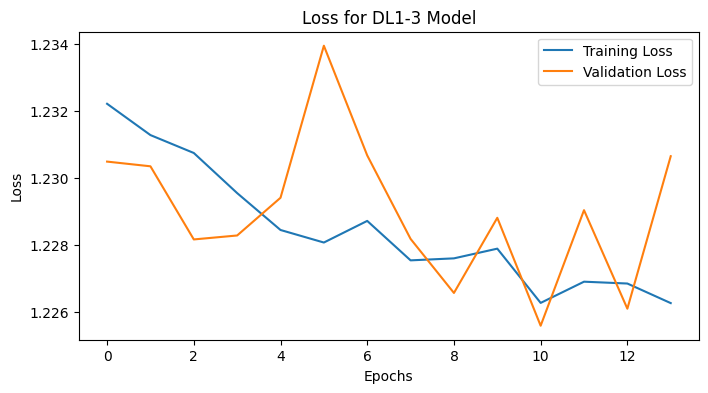

In [4]:
torch.save(model, f'model_DL{MODEL_NUM}-{MODEL_VERSION}.pth')

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(train_loss_hist, label = 'Training Loss')
plt.plot(valid_loss_hist, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.ylim(0, None)
plt.title(f'Loss for DL{MODEL_NUM}-{MODEL_VERSION} Model')
plt.legend()
plt.savefig(f'Loss_DL{MODEL_NUM}-{MODEL_VERSION}.png')
plt.show()

In [5]:
import pickle

pickle.dump(train_loss_hist, open(f'pickle/training_loss_history_DL{MODEL_NUM}-{MODEL_VERSION}.pkl', 'wb'))
pickle.dump(valid_loss_hist, open(f'pickle/validation_loss_history_DL{MODEL_NUM}-{MODEL_VERSION}.pkl', 'wb'))

In [6]:
model_loaded = torch.load(f'model_DL{MODEL_NUM}-{MODEL_VERSION}.pth')

In [14]:
board = chess.Board()

e2e4


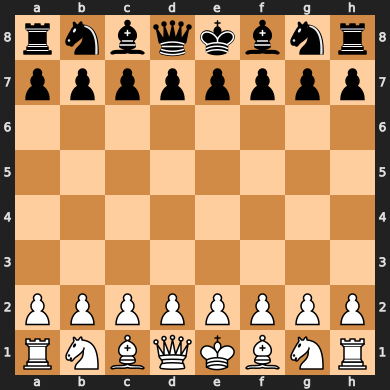

In [19]:
move = lib.predict(model_loaded, board.fen())
print(move)
board

In [21]:
move

Move.from_uci('e2e4')

In [22]:
board.push_uci(move)
board

TypeError: object of type 'Move' has no len()

In [16]:
move = lib.predict(model_loaded, board.fen())

In [17]:
move = 'e4f6'